# Lecture 7. Word Embeddings and Document Embeddings

# Setup

In [1]:
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df = df[pd.notnull(df['authorship'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vec-3grams-1.pkl')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

2023-10-25 19:01:57.045766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import warnings; warnings.simplefilter('ignore')  # Ignore warnings

#%matplotlib inline  # Set up Matplotlib to display plots inline
import pandas as pd  # Import Pandas

# Load a pickled DataFrame with gzip compression
df = pd.read_pickle('sc_cases_cleaned.pkl', compression='gzip')

# Reset the DataFrame's index and drop the previous index
df = df.reset_index(drop=True)

# Create a new 'author_id' column based on categorical codes of 'authorship'
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)

# Remove rows with missing 'authorship'
df = df[pd.notnull(df['authorship'])]

import numpy as np  # Import NumPy

# Load another pickled DataFrame
vocab = pd.read_pickle('vec-3grams-1.pkl')

from IPython.display import SVG  # Import functions for displaying SVG images
from keras.utils.vis_utils import model_to_dot  # Import Keras model visualization


In [4]:
vocab

CountVectorizer(max_df=0.9, max_features=1000, min_df=0.01, ngram_range=(1, 3),
                stop_words='english')

In [5]:
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,year,log_cite_count,preprocessed,author_id
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,2003,7.981392,justic ginsburg deliv opinion court motion fed...,2
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,2003,4.762174,justic steven deliv opinion court unit state i...,9
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,2005,10.058952,justic oconnor deliv opinion court confront pr...,4
3,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,2005,4.430817,justic kennedi deliv opinion court state alask...,3
4,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,2005,8.349957,justic kennedi deliv opinion court case involv...,3


# Word2Vec in gensim

In [6]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
num_words= 300
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               vector_size=num_words,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([-0.03529686,  0.12819882,  0.01952168, -0.0170781 ,  0.035405  ,
       -0.04123079, -0.01383281, -0.06480107,  0.04683938, -0.06586543,
        0.08183035, -0.04188716,  0.05033736, -0.09729395,  0.01204346,
       -0.05069168,  0.04055716,  0.04987177, -0.02030406,  0.09652719,
        0.01029317, -0.07329801,  0.08335624, -0.04447078, -0.06638376,
       -0.01496779,  0.06938571,  0.00878065,  0.04040879,  0.08511036,
        0.00693453, -0.04779306,  0.01599757,  0.03320653, -0.00134242,
        0.00418378,  0.05124918, -0.0444264 , -0.00253607,  0.02070107,
        0.11554875,  0.01610432, -0.0031942 , -0.02324933,  0.02015596,
       -0.04041125,  0.04935767, -0.01721922, -0.04575262, -0.03514088,
       -0.00667139, -0.06172882, -0.11386842, -0.13092925, -0.06371295,
       -0.04699956, -0.00258503,  0.10679814, -0.01532412,  0.00369781,
       -0.04953594, -0.0022969 ,  0.07800304, -0.12301836,  0.07162702,
       -0.08137304,  0.02715467,  0.01395728,  0.00507713, -0.13

In [7]:
w2v.wv.similarity('judg','juri') # similarity 

0.5462777

In [8]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.5927864909172058),
 ('juri', 0.5462777614593506),
 ('court', 0.5229708552360535),
 ('prosecutor', 0.5047777891159058),
 ('factfind', 0.496646523475647),
 ('speedi', 0.49458885192871094),
 ('panel', 0.4891902804374695),
 ('unanim', 0.48818978667259216),
 ('special', 0.48012247681617737),
 ('alj', 0.47159579396247864)]

In [9]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('bench', 0.561948299407959),
 ('magistr', 0.5129990577697754),
 ('panel', 0.4857567548751831),
 ('sit', 0.4781392514705658),
 ('prosecutor', 0.46885937452316284),
 ('unanim', 0.4621812105178833),
 ('credibl', 0.45441508293151855),
 ('juri', 0.45093971490859985),
 ('court', 0.44190165400505066),
 ('imparti', 0.4375374913215637)]

In [10]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)

judge_clust = kmw.labels_[w2v.wv.key_to_index['judg']]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust and i<=100:
        print(w2v.wv.index_to_key[i])

defend
sentenc
trial
judg
juri


# Pre-trained vectors

In [11]:
import spacy
en = spacy.load('en_core_web_sm')
apple = en('apple') 
apple.vector # vector for 'apple'

array([-1.2599487 , -0.87038326, -1.0834986 ,  0.5798379 ,  0.03857595,
       -0.02588724,  0.9775548 ,  0.31093895,  0.19412561, -0.8062178 ,
        0.43808204, -1.8498268 , -0.30574286,  0.5693637 ,  0.42844394,
        0.69174224, -0.7197368 , -1.2614795 ,  0.83457553,  0.14667332,
        0.12171662,  0.48029226,  0.50147873, -0.4299112 ,  0.5533447 ,
        0.8749714 ,  0.71914   ,  0.5731143 , -0.5064311 ,  0.38493997,
       -0.31778833,  0.18084693,  0.5162936 , -0.00233826,  0.1870515 ,
       -1.3773322 ,  1.009095  , -0.10771251,  1.6994228 ,  0.78603184,
       -0.8166558 ,  0.57896584, -0.5232718 ,  0.7045958 , -0.46308953,
       -0.37629813, -0.38788998,  0.1730735 , -0.05550597, -0.17245518,
        0.62919456,  0.87473   ,  0.60047954, -0.27686393,  0.8524152 ,
       -0.28676936,  0.9972549 , -0.71060055,  0.11830124, -0.37214422,
       -1.3039289 , -0.02281845,  0.4063236 , -0.43118405,  0.9401908 ,
       -0.02761412, -0.39026427, -0.29733896,  0.78710043, -0.34

In [12]:
apple.similarity(apple)

1.0

In [13]:
orange = en('orange')
apple.similarity(orange)

0.35815910581210864

In [14]:
import spacy
# !python -m spacy download de_core_news_sm
de = spacy.load('de_core_news_sm')
apfel = de('apfel')
orange = de('orange')
apfel.similarity(orange)

0.37115291343357987

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 57108 samples in 0.003s...
[t-SNE] Computed neighbors for 57108 samples in 12.716s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57108
[t-SNE] Computed conditional probabilities for sample 2000 / 57108
[t-SNE] Computed conditional probabilities for sample 3000 / 57108
[t-SNE] Computed conditional probabilities for sample 4000 / 57108
[t-SNE] Computed conditional probabilities for sample 5000 / 57108
[t-SNE] Computed conditional probabilities for sample 6000 / 57108
[t-SNE] Computed conditional probabilities for sample 7000 / 57108
[t-SNE] Computed conditional probabilities for sample 8000 / 57108
[t-SNE] Computed conditional probabilities for sample 9000 / 57108
[t-SNE] Computed conditional probabilities for sample 10000 / 57108
[t-SNE] Computed conditional probabilities for sample 11000 / 57108
[t-SNE] Computed conditional probabilities for sample 12000 / 57108
[t-SNE] Computed conditional probabilities for s

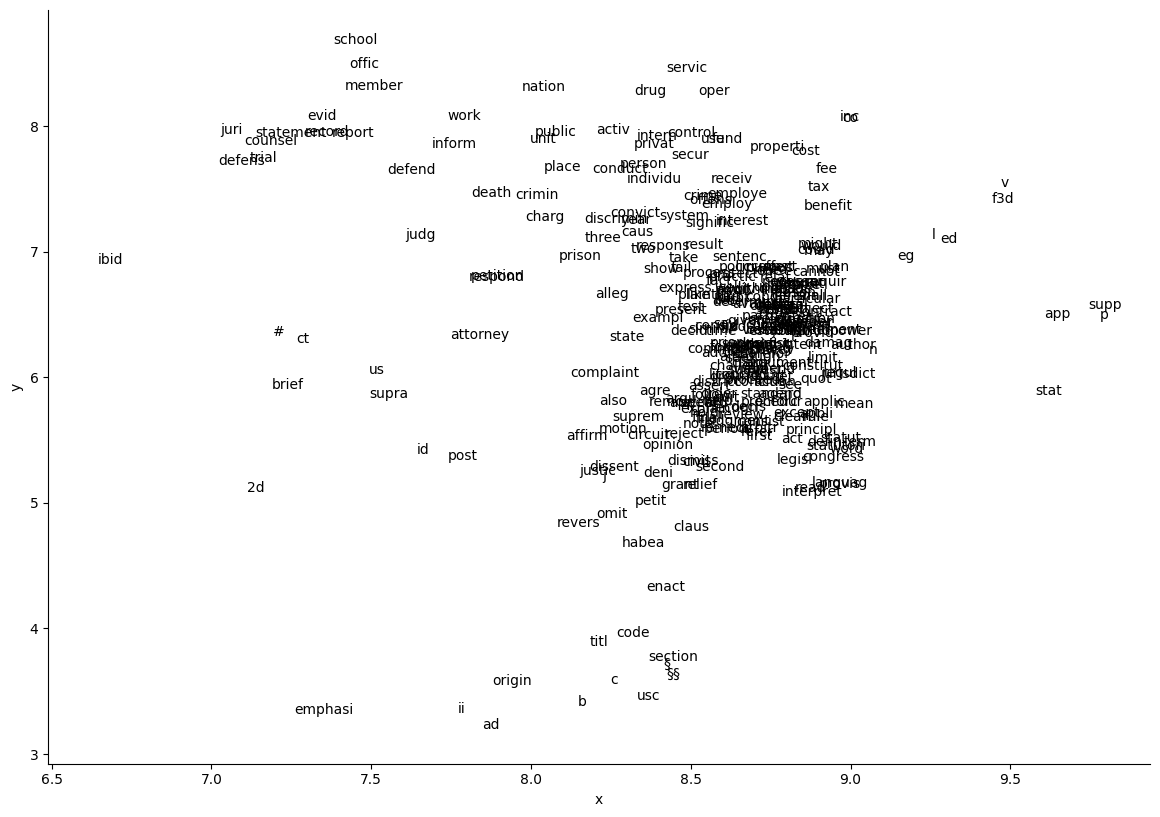

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 57108 samples in 0.003s...
[t-SNE] Computed neighbors for 57108 samples in 13.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57108
[t-SNE] Computed conditional probabilities for sample 2000 / 57108
[t-SNE] Computed conditional probabilities for sample 3000 / 57108
[t-SNE] Computed conditional probabilities for sample 4000 / 57108
[t-SNE] Computed conditional probabilities for sample 5000 / 57108
[t-SNE] Computed conditional probabilities for sample 6000 / 57108
[t-SNE] Computed conditional probabilities for sample 7000 / 57108
[t-SNE] Computed conditional probabilities for sample 8000 / 57108
[t-SNE] Computed conditional probabilities for sample 9000 / 57108
[t-SNE] Computed conditional probabilities for sample 10000 / 57108
[t-SNE] Computed conditional probabilities for sample 11000 / 57108
[t-SNE] Computed conditional probabilities for sample 12000 / 57108
[t-SNE] Computed conditional probabilities for s

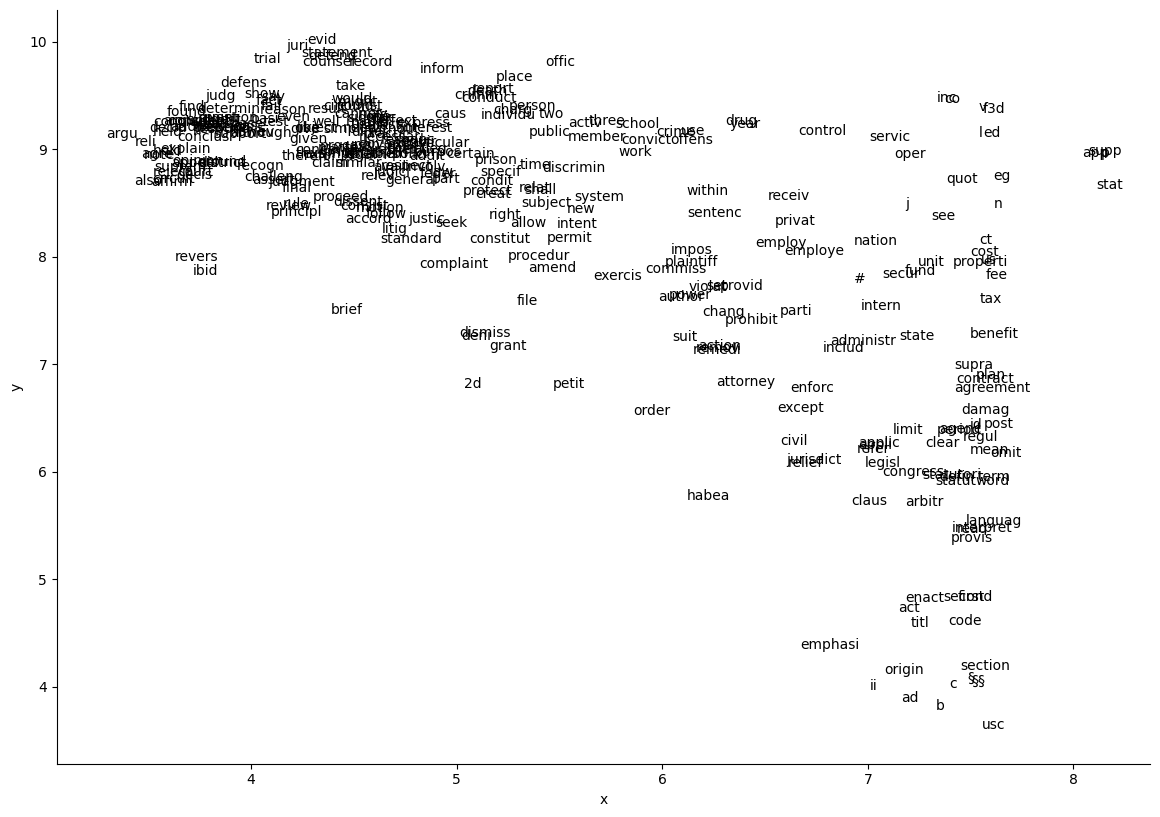

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 57108 samples in 0.002s...
[t-SNE] Computed neighbors for 57108 samples in 13.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57108
[t-SNE] Computed conditional probabilities for sample 2000 / 57108
[t-SNE] Computed conditional probabilities for sample 3000 / 57108
[t-SNE] Computed conditional probabilities for sample 4000 / 57108
[t-SNE] Computed conditional probabilities for sample 5000 / 57108
[t-SNE] Computed conditional probabilities for sample 6000 / 57108
[t-SNE] Computed conditional probabilities for sample 7000 / 57108
[t-SNE] Computed conditional probabilities for sample 8000 / 57108
[t-SNE] Computed conditional probabilities for sample 9000 / 57108
[t-SNE] Computed conditional probabilities for sample 10000 / 57108
[t-SNE] Computed conditional probabilities for sample 11000 / 57108
[t-SNE] Computed conditional probabilities for sample 12000 / 57108
[t-SNE] Computed conditional probabilities for s

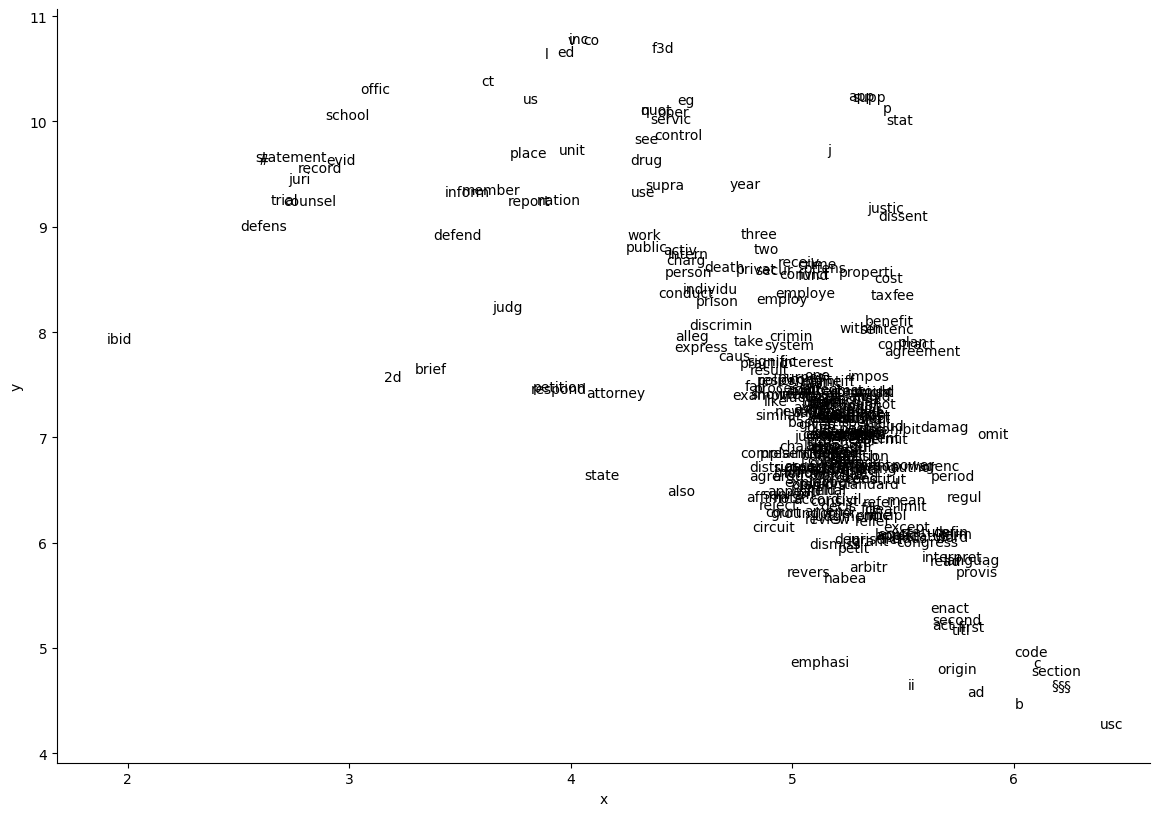

In [15]:
# show the vectors
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

w2v = Word2Vec(min_count=1)
w2v.build_vocab(sentences)  # prepare the model vocabulary
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=w2v.epochs)

df3 = pd.DataFrame(list(w2v.wv.key_to_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(3):
    if i > 0:
        w2v.train(sentences, total_examples=w2v.corpus_count, epochs=1)
    
    word_vectors = w2v.wv.vectors  # Access word vectors from the Word2Vec model
    wv_tsne = tsne.fit_transform(word_vectors)

    # Make sure the length of wv_tsne matches the length of df3
    df3['x'] = wv_tsne[:num_words, 0]
    df3['y'] = wv_tsne[:num_words, 1]
    
    plot = sns.relplot(data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()


# GloVe (this is not working, but an example)

In [16]:
#!pip install glove-python-binary 
#!pip install glove_python for other versions

#import itertools
#from glove import Corpus, Glove

#corpus = Corpus()
#corpus.fit(sentences, window=10)
#glove = Glove(no_components=100, learning_rate=0.05)

#glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
#glove.add_dictionary(corpus.dictionary)
#glove.word_vectors[glove.dictionary['judg']]
#glove.most_similar('judg')


# Word Mover Distance

In [17]:
#!pip install pyemd

In [18]:
import spacy 

nlp = spacy.load('en_core_web_sm')

doc1 = nlp("Politician speaks to the media in Illinois.")
doc2 = nlp("The president greets the press in Chicago.")


w2v.wv.wmdistance(doc1, doc1)

inf

# **Document Embeddings**

In [25]:
# ###
# # Setup --> todo use old sentences
# ###
# import numpy as np
# import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')

import spacy
nlp = spacy.load('en_core_web_sm')

# word2vec requires sentences as input
sentences = []
for doc in df1['snippet']:
    sents = [sent for sent in nlp(doc).sents]
    sentences += sents
#     sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

In [26]:
df1

,court_id,author_id,state,year,dateFiled,citeCount,snippet
0,nj,NaN,NJ,1965,1965-09-14T00:00:00Z,8,N.J. ( )\n A. d \nIN RE WAIVER OF DEATH PE...
1,fla,4019.0,FL,1973,1973-07-26T00:00:00Z,552,"whether the death penalty is, per se, unconsti..."
2,texcrimapp,5765.0,TX,1975,1975-04-16T00:00:00Z,143,# ;s contention that the assessment of the dea...
3,nm,NaN,NM,2009,2009-11-30T00:00:00Z,0,. d ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...
4,texcrimapp,5758.0,TX,1944,1944-12-20T00:00:00Z,56,assume the district attorney orally waived the...
...,...,...,...,...,...,...,...
32562,ohioctapp,8055.0,OH,2017,2017-07-20T00:00:00Z,0,of two counts of aggravated murder with deat...
32563,cal,NaN,CA,2017,2017-07-20T00:00:00Z,0,his general views about the death penalty as ...
32564,neb,NaN,NE,2017,2017-07-21T00:00:00Z,0,"been subject to the death\npenalty, because Ne..."
32565,ohio,5374.0,OH,2017,2017-07-25T00:00:00Z,0,that Indiana law permits imposition of the de...


**Doc2Vec**

In [29]:
###
# Doc2Vec
###

from nltk import word_tokenize
docs = []

for i, row in df1.iterrows():
    docs += [word_tokenize(row['snippet'])]
shuffle(docs)

In [30]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
doc_iterator = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
d2v = Doc2Vec(doc_iterator,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size

In [32]:
d2v.save('d2v-vectors.pkl')

In [33]:
D = d2v.docvecs.vectors
D.shape

(32567, 100)

In [34]:
D

array([[-0.03784064,  0.01365797, -0.01227487, ..., -0.02242731,
         0.01417948, -0.00836171],
       [-0.0397767 ,  0.0596798 , -0.00752593, ..., -0.05078941,
         0.01908517, -0.01496317],
       [-0.03626244,  0.0217675 ,  0.02324189, ..., -0.02540343,
         0.0437685 , -0.01815565],
       ...,
       [-0.03046013,  0.03448714, -0.00978671, ..., -0.02996108,
         0.03045505, -0.01322176],
       [-0.04972948,  0.04818527, -0.01775591, ..., -0.05626922,
         0.01011454, -0.01602721],
       [-0.00898123,  0.04832184, -0.00573149, ..., -0.02164833,
         0.01257681, -0.00842335]], dtype=float32)

In [35]:
# infer vectors for new documents
a = d2v.infer_vector(['the judge on the court'])

b = d2v.infer_vector(['the jury and the judge'])

c = d2v.infer_vector(['cats hunt mice'])

In [36]:
a.shape, b.shape

((100,), (100,))

In [37]:
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(b, axis=0)))
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(c, axis=0)))

[[0.1506425]]
[[0.00079509]]


In [38]:
# get all pair-wise document similarities
pairwise_sims = cosine_similarity(D)

In [39]:
pairwise_sims[:3,:3]

array([[1.        , 0.7911093 , 0.85536253],
       [0.7911093 , 0.9999999 , 0.8270349 ],
       [0.85536253, 0.8270349 , 0.9999999 ]], dtype=float32)

In [40]:
# Document clusters
from sklearn.cluster import KMeans

# create 50 clusters of similar documents
num_clusters = 50
kmw = KMeans(n_clusters=num_clusters)
kmw.fit(D)

KMeans(n_clusters=50)

In [41]:
# Documents from an example cluster
for i, doc in enumerate(docs):
    if kmw.labels_[i] == 25:
        print(' '.join(doc[:9]))
    if i == 1000:
        break

of Review The Anti-Terrorism and Effective Death Penalty Act
ANALYSIS The Anti-Terrorism and Effective Death Penalty Act of
amended by the Anti-Terrorism and Effective Death Penalty Act
Challenges to the Death Penalty Statute Defendant advances challenges
legislature from amending death penalty statutes and enacting new
enactment of the Antiterrorism and Effective Death Penalty Act
the venire about mental mitigation and the death penalty
enacted the Antiterrorism and Effective Death Penalty Act (
timely under the Anti-Terrorism and Effective Death Penalty Act
April , , the Antiterrorism and Effective Death Penalty
amended by the Anti-terrorism and Effective Death Penalty Act
amended by the Antiterrorism and Effective Death Penalty Act
contained in the Anti-Terrorism and Effective Death Penalty Act
first through the Antiterrorism and Effective Death Penalty Act
challenge the constitutionality of the Illinois death penalty statute
time-barred under the Anti-Terrorism and Effective Death 

In [111]:
# t-SNE for visualization
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
# d2v_tsne = tsne.fit_transform(D)

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(D)
pca.explained_variance_ratio_

array([0.48037323, 0.0651226 , 0.05143629], dtype=float32)

In [53]:
#vdf = pd.DataFrame(Xpca,
#                  columns=['x-tsne', 'y-tsne'])
#vdf['cluster'] = kmw.labels_

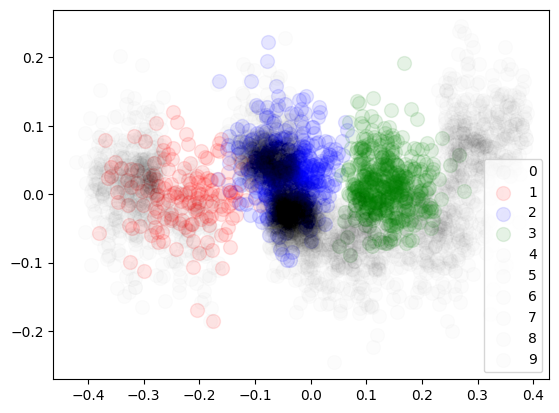

In [43]:
#%% PCA Viz
import matplotlib.pyplot as plt

#plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)

cdict = {1: 'red', 2: 'blue', 3: 'green'}
fig, ax = plt.subplots()
#for g, label in cdict.items():
for g in np.unique(kmw.labels_):
    ix = np.where(kmw.labels_ == g)
    #ix = np.where(kmw == g)
    #    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
    if g in cdict:
        # use color from cdict
        color = cdict[g]
        ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.1)
    else:
        if g < 10:
            color = "black"
            ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.01)
    

        
ax.legend()
plt.show()

In [44]:
# sample 100 texts to show different document embeddings techniques

texts = df1["snippet"][:100]
text = texts[0]
text, texts

('N.J.   ( )\n  A. d  \nIN RE WAIVER OF DEATH PENALTY.\nThe Supreme Court of New Jersey.\nSeptember & ; and County Court Judges\n\nRe: Waiver of the Death Penalty\n*  The Supreme Court is concerned by the excessive& ;cases where the prosecutor is not seeking the death penalty. It is cognizant of the fact that this situation& ;Although the prosecutor had a right to waive the death penalty and so inform the jury, the jury nevertheless& ;would assume, as did the prosecutor, that the death penalty would not be returned as it was not asked for',
 0     N.J.   ( )\n  A. d  \nIN RE WAIVER OF DEATH PE...
 1     whether the death penalty is, per se, unconsti...
 2     # ;s contention that the assessment of the dea...
 3     . d   ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...
 4     assume the district attorney orally waived the...
                             ...                        
 95    guilty as to all defendants and imposing the d...
 96     present death penalty statutes, juries could .